In [11]:
from zipfile import ZipFile
import os
import sys
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix, hstack
import numpy as np
import pandas as pd
from pandas.io import sql
import sqlite3
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn import cross_validation

datapath = "/Users/Renato Aranha/Documents/Python Scripts/bases_TD/"

In [12]:
app_event = "app_events.csv"
app_label = "app_labels.csv"
event = "events.csv"
gender_ag_test = "gender_age_test.csv"
gender_ag_train = "gender_age_train.csv"
label_category = "label_categories.csv"
phone_brand_device_mode = "phone_brand_device_model.csv"
sample_submission = "sample_submission.csv"

In [13]:
app_events = pd.read_csv(os.path.join(datapath,app_event),dtype={'is_active':bool})
app_labels = pd.read_csv(os.path.join(datapath,app_label))
events = pd.read_csv(os.path.join(datapath,event))
gender_age_test = pd.read_csv(os.path.join(datapath,gender_ag_test),index_col='device_id')
gender_age_train = pd.read_csv(os.path.join(datapath,gender_ag_train),index_col='device_id')
label_categories = pd.read_csv(os.path.join(datapath,label_category))
phone = pd.read_csv(os.path.join(datapath,phone_brand_device_mode))
phone_dedup = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
sample_submission = pd.read_csv(os.path.join(datapath,sample_submission))

# Análise exploratória

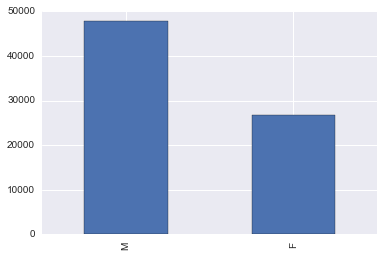

In [14]:
gender_age_train.gender.value_counts().plot(kind='bar')

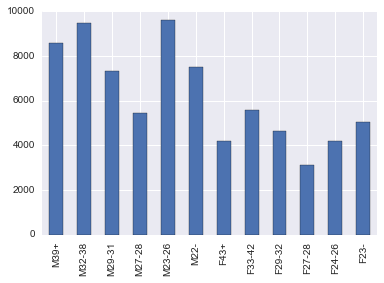

In [15]:
gender_age_train.group.value_counts().sort_index(ascending=False).plot(kind='bar')

In [16]:
events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [17]:
phone_dedup.head()

,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4
3669464369358936369,SUGAR,时尚手机
-5019277647504317457,三星,Galaxy Note 2


In [18]:
gender_age_train.head()

,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38
-4938849341048082022,M,30,M29-31
245133531816851882,M,30,M29-31


## gerando matrizes esparsas para relacionar device_id com brand:

In [19]:
gender_age_train['trainrow'] = np.arange(gender_age_train.shape[0]) 
#acima: criando um vetor coluna cujas componentes são os números das linhas do dataframe gender_age_train
gender_age_test['testrow'] = np.arange(gender_age_test.shape[0])

In [20]:
brandencoder = LabelEncoder().fit(phone_dedup.phone_brand)
phone_dedup['brand'] = brandencoder.transform(phone_dedup['phone_brand'])
gender_age_train['brand'] = phone_dedup['brand']
gender_age_test['brand'] = phone_dedup['brand']

In [21]:
Xtr_brand = csr_matrix((np.ones(gender_age_train.shape[0]), (gender_age_train.trainrow, gender_age_train.brand)))
#criando matriz com: 
#qtd linhas = qtd linhas do dataframe gender_age_train
#qtd colunas = qtd de marcas distintas (qtd de brands) no dataframe gender_age_train
#os elementos das células com as combinações acima sendo iguais a 1

#abaixo: fazendo a mesma operação com a base de teste
Xte_brand = csr_matrix((np.ones(gender_age_test.shape[0]), (gender_age_test.testrow, gender_age_test.brand)))

In [22]:
Xte_brand.shape

(112071, 131)

## gerando matrizes esparsas para relacionar device_id com concatenado de model e brand :

In [23]:
m = phone_dedup.phone_brand.str.cat(phone_dedup.device_model) #concatenando phone_brand e device_model (e fazendo o encode)
modelencoder = LabelEncoder().fit(m)
phone_dedup['model'] = modelencoder.transform(m)

gender_age_train['model'] = phone_dedup['model']
gender_age_test['model'] = phone_dedup['model']

Xtr_model = csr_matrix((np.ones(gender_age_train.shape[0]), (gender_age_train.trainrow, gender_age_train.model)))
Xte_model = csr_matrix((np.ones(gender_age_test.shape[0]), (gender_age_test.testrow, gender_age_test.model)))

In [24]:
m.head()

device_id
-8890648629457979026               小米红米
 1277779817574759137             小米MI 2
 5137427614288105724        三星Galaxy S4
 3669464369358936369          SUGAR时尚手机
-5019277647504317457    三星Galaxy Note 2
Name: phone_brand, dtype: object

In [25]:
phone_dedup.head()

,phone_brand,device_model,brand,model
device_id,,,,
-8890648629457979026,小米,红米,51,858
1277779817574759137,小米,MI 2,51,843
5137427614288105724,三星,Galaxy S4,15,371
3669464369358936369,SUGAR,时尚手机,9,166
-5019277647504317457,三星,Galaxy Note 2,15,347


In [26]:
Xtr_model.shape

(74645, 1667)

# gerando matrizes esparsas para saber quais aplicativos estão em cada device 

In [28]:
events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [27]:
app_events.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,True
1,2,-5720078949152207372,1,False
2,2,-1633887856876571208,1,False
3,2,-653184325010919369,1,True
4,2,8693964245073640147,1,True


In [29]:
appencoder = LabelEncoder().fit(app_events.app_id)
app_events['app'] = appencoder.transform(app_events.app_id)
napps = len(appencoder.classes_)

app_events.head()

,event_id,app_id,is_installed,is_active,app
0,2,5927333115845830913,1,True,15408
1,2,-5720078949152207372,1,False,3384
2,2,-1633887856876571208,1,False,7620
3,2,-653184325010919369,1,True,8902
4,2,8693964245073640147,1,True,18686


In [72]:
deviceapps = pd.merge(app_events[app_events['is_installed']==1],events,how='left',on='event_id')
deviceapps2 = pd.merge(deviceapps[['device_id','app']],gender_age_train.reset_index(),how='left',on='device_id')

In [73]:
deviceapps3 = pd.merge(deviceapps2[['device_id','app','trainrow']],gender_age_test.reset_index(),how='left',on='device_id')

In [74]:
deviceapps3.drop_duplicates('device_id',keep='first').head()

,device_id,app,trainrow,testrow,brand,model
0,-6401643145415154744,15408,NaN,68691.0,15.0,329.0
19,1476664663289716375,1819,51154.0,NaN,NaN,NaN
57,5990807147117726237,4071,NaN,101850.0,120.0,1612.0
97,-2073340001552902943,1819,NaN,26034.0,30.0,606.0
132,9070651185984875886,1819,NaN,76410.0,31.0,738.0


In [75]:
deviceapps = deviceapps3.drop_duplicates('device_id',keep='first')

In [76]:
deviceapps.head()

,device_id,app,trainrow,testrow,brand,model
0,-6401643145415154744,15408,NaN,68691.0,15.0,329.0
19,1476664663289716375,1819,51154.0,NaN,NaN,NaN
57,5990807147117726237,4071,NaN,101850.0,120.0,1612.0
97,-2073340001552902943,1819,NaN,26034.0,30.0,606.0
132,9070651185984875886,1819,NaN,76410.0,31.0,738.0


In [77]:
apoio = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(apoio.shape[0]), (apoio.trainrow, apoio.app)), shape=(gender_age_train.shape[0],napps))

apoio = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(apoio.shape[0]), (apoio.testrow, apoio.app)),  shape=(gender_age_test.shape[0],napps))

print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


# trabalhando latitude e longitude

In [95]:
events['latlong'] = events['latitude'] + events['longitude']
events.head()

,event_id,device_id,timestamp,longitude,latitude,latlong
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,152.62
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,134.62
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,136.30
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,127.55
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,144.54


In [96]:
appencoder = LabelEncoder().fit(events.latlong)
events['encoded_latlong'] = appencoder.transform(events.latlong)

events.head()

,event_id,device_id,timestamp,longitude,latitude,latlong,encoded_latlong
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,152.62,4445
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,134.62,1847
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,136.30,2089
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,127.55,921
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,144.54,3266


In [ ]:
latlong = pd.merge(app_events[app_events['is_installed']==1],events,how='left',on='event_id')
latlong2 = pd.merge(latlong[['device_id','encoded_latlong']],gender_age_train.reset_index(),how='left',on='device_id')
latlong3 = pd.merge(latlong2[['device_id','encoded_latlong','trainrow']],gender_age_test.reset_index(),how='left',on='device_id')

In [ ]:
latlong3.drop_duplicates('device_id',keep='first').head()

# gerando matrizes esparsas para saber quais labels (e consequentemente quais categorias) estão em cada device 

In [37]:
#regerando o dataframe "app_labels, para deixar apenas os app_ids que existem no dataframe de eventos (app_events)
app_labels = app_labels.loc[app_labels.app_id.isin(app_events.app_id.unique())]
#agora vamos aplicar o encoding no app_id, e criar uma nova coluna em app_labels. Podemos usar o mesmo enconder que utilizamos
#no passo anterior (matrizes esparsas para saber quais aplicativos estão em cada device).
app_labels['app'] = appencoder.transform(app_labels.app_id)

labelencoder = LabelEncoder().fit(app_labels.label_id)
app_labels['label'] = labelencoder.transform(app_labels.label_id)

nlabels = len(labelencoder.classes_) #qtd de labels

In [38]:
app_labels.head()

,app_id,label_id,app,label
0,7324884708820027918,251,17355,207
1,-4494216993218550286,251,4618,207
2,6058196446775239644,406,15548,247
3,6058196446775239644,407,15548,248
4,8694625920731541625,406,18689,247


In [78]:
devicelabels = pd.merge(deviceapps[['device_id','app']],app_labels[['app','label']],how='inner',on='app')
devicelabels2 = pd.merge(devicelabels,gender_age_train.reset_index(),how='left',on='device_id')   
devicelabels3 = pd.merge(devicelabels2,gender_age_test.reset_index(),how='left',on='device_id')
devicelabels = devicelabels3
devicelabels.head()

,device_id,app,label,gender,age,group,trainrow,brand_x,model_x,testrow,brand_y,model_y
0,-6401643145415154744,15408,250,NaN,NaN,NaN,NaN,NaN,NaN,68691.0,15.0,329.0
1,-6401643145415154744,15408,276,NaN,NaN,NaN,NaN,NaN,NaN,68691.0,15.0,329.0
2,-6401643145415154744,15408,270,NaN,NaN,NaN,NaN,NaN,NaN,68691.0,15.0,329.0
3,-6401643145415154744,15408,249,NaN,NaN,NaN,NaN,NaN,NaN,68691.0,15.0,329.0
4,-6401643145415154744,15408,138,NaN,NaN,NaN,NaN,NaN,NaN,68691.0,15.0,329.0


In [79]:
dl = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(dl.shape[0]), (dl.trainrow, dl.label)), 
                      shape=(gender_age_train.shape[0],nlabels))
dl = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(dl.shape[0]), (dl.testrow, dl.label)), 
                      shape=(gender_age_test.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


## concatenando as features

In [80]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')

print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21527), test shape (112071, 21527)


## cross validation

In [81]:
targetencoder = LabelEncoder().fit(gender_age_train.group)
y = targetencoder.transform(gender_age_train.group)
nclasses = len(targetencoder.classes_)

In [82]:
def score(clf, random_state = 0):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    print('')
    return log_loss(y, pred)

In [89]:
from sklearn.ensemble import RandomForestClassifier
score(RandomForestClassifier(n_estimators=300, 
                              criterion='gini', 
                              max_depth=None, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              min_weight_fraction_leaf=0.0, 
                              max_features='auto', 
                              max_leaf_nodes=None, 
                              bootstrap=True, 
                              oob_score=False, 
                              n_jobs=-1, 
                              random_state=0, 
                              verbose=0, 
                              warm_start=False, 
                              class_weight=None))

3.2998230008324936

In [88]:
from sklearn.ensemble import AdaBoostClassifier
score(AdaBoostClassifier(base_estimator=None,
                          n_estimators=200,
                          learning_rate=0.1,
                          algorithm='SAMME.R',
                          random_state=0))

2.4763916786782763

In [46]:
from sklearn.linear_model import SGDClassifier
score(SGDClassifier(loss='log',
                     penalty='l2', 
                     alpha=0.0001,
                     l1_ratio=0.15, 
                     fit_intercept=True,
                     n_iter=200, 
                     shuffle=True,
                     verbose=0,
                     epsilon=0.1,
                     n_jobs=-1,
                     random_state=0,
                     learning_rate='optimal',
                     eta0=0.0, 
                     power_t=0.5,
                     class_weight=None,
                     warm_start=False, 
                     average=False))

2.3842726382274599

In [67]:
#testando Regressão Logística (vamos tentar calibrar a constante de regularização C, cujo valor padrão é 1)
#rodar várias vezes (tentativa e erro)

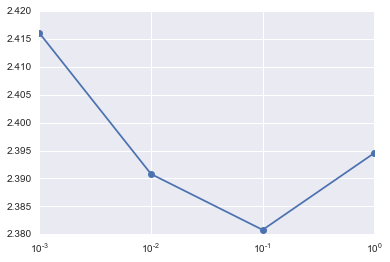

In [83]:
Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o');

In [92]:
score(LogisticRegression(C=0.07))

2.3815215449275717

In [53]:
score(LogisticRegression(C=0.1, multi_class='multinomial',solver='lbfgs'))

2.3806131759671767

In [54]:
score(LogisticRegression(C=0.1, multi_class='multinomial',solver='newton-cg'))

2.3805834771072694

In [66]:
#mesmo padrão do exemplo do Titanic:
score(LogisticRegression(penalty='l2',
                           dual=False, 
                           tol=0.0001, 
                           C=1.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           class_weight=None, 
                           random_state=0, 
                           solver='liblinear', 
                           max_iter=100, 
                           multi_class='ovr', 
                           verbose=0, 
                           warm_start=False, 
                           n_jobs=-1))

2.4045222947077129

In [55]:
clf = LogisticRegression(C=0.1, multi_class='multinomial',solver='newton-cg')
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = gender_age_test.index, columns=targetencoder.classes_)
pred.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.048845,0.056453,0.064584,0.066327,0.068585,0.046614,0.113889,0.160702,0.078896,0.098849,0.115033,0.081223
-1547860181818787117,0.042565,0.053013,0.037488,0.035840,0.061695,0.072630,0.087661,0.139541,0.075808,0.095785,0.139655,0.158318
7374582448058474277,0.072229,0.099072,0.060514,0.090659,0.127925,0.102595,0.057648,0.073699,0.038536,0.083180,0.092150,0.101792
-6220210354783429585,0.014297,0.018877,0.017996,0.029974,0.087772,0.133638,0.030609,0.073372,0.045077,0.142658,0.177412,0.228317
-5893464122623104785,0.037568,0.072202,0.040176,0.063464,0.049639,0.039161,0.072683,0.170838,0.107681,0.105636,0.146569,0.094384


In [56]:
pred.to_csv('logreg_subm.csv',index=True)